Part 1 setup

1.1 Environment Check

In [ ]:
import sys
import os

# Check if running in Colab
IN_COLAB = 'google.colab' in sys.modules
print(f"Running in Google Colab: {IN_COLAB}")

# Check GPU availability
import torch
print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ WARNING: No GPU detected. Training will be very slow!")
    print("In Colab: Runtime -> Change runtime type -> GPU")

Running in Google Colab: True

PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA version: 12.6
GPU device: NVIDIA A100-SXM4-80GB
GPU memory: 85.17 GB


1.2 Clone LabTop

In [ ]:
import os

# Clone the repository if not already present
if not os.path.exists('LabTOP'):
    !git clone https://github.com/sujeongim/LabTOP.git


%cd LabTOP
!pwd

Cloning into 'LabTOP'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 166 (delta 74), reused 117 (delta 42), pack-reused 0 (from 0)
Receiving objects: 100% (166/166), 339.42 KiB | 3.00 MiB/s, done.
Resolving deltas: 100% (74/74), done.
/content/LabTOP/LabTOP
/content/LabTOP/LabTOP


1.3 Install packages

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

print("PyTorch installed!")

Looking in indexes: https://download.pytorch.org/whl/cu118
PyTorch installed!


In [ ]:
!pip install transformers datasets tokenizers
!pip install scikit-learn pandas numpy
!pip install matplotlib seaborn
!pip install tqdm
!pip install omegaconf hydra-core
!pip install pyyaml
!pip install wandb  # For experiment tracking (optional)

print("Common dependencies installed!")

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_set_from_installed()
              

1.4 Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW  # ← FIXED: Now from torch.optim

# Transformers and tokenization
from transformers import (
    GPT2Config,
    GPT2LMHeadModel,
    GPT2Tokenizer,
    get_linear_schedule_with_warmup
)

# Data processing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Utilities
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import pickle
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


1.5 Project structure

In [ ]:
directories = [
    'data/raw',           # Raw MIMIC-IV data
    'data/processed',     # Preprocessed data
    'data/splits',        # Train/val/test splits
    'models',             # Saved model checkpoints
    'results',            # Evaluation results
    'plots',              # Visualizations
    'logs'                # Training logs
]

for directory in directories:
    os.makedirs(directory, exist_ok=True)

print("\n📁 Project structure created!")


📁 Project structure created!


1.6 Config

In [ ]:
# LabTOP Configuration (based on paper)
config = {
    'model': {
        'n_layer': 12,
        'n_head': 12,
        'n_embd': 768,
        'vocab_size': 50000,
        'max_position_embeddings': 4096,
        'dropout': 0.1,
        'attn_dropout': 0.1,
    },
    'training': {
        'batch_size': 32,
        'learning_rate': 5e-5,
        'num_epochs': 50,
        'warmup_steps': 1000,
        'gradient_accumulation_steps': 1,
        'max_grad_norm': 1.0,
        'weight_decay': 0.01,
        'adam_epsilon': 1e-8,
    },
    'data': {
        'max_seq_length': 4096,
        'subset_ratio': 0.1,
        'min_lab_count': 100,
        'num_workers': 2,
        'train_ratio': 0.7,
        'val_ratio': 0.15,
        'test_ratio': 0.15,
    },
    'tokenization': {
        'digit_wise': True,
        'use_absolute_time': True,
        'time_format': 'absolute',
    },
    'special_tokens': {
        'pad_token': '',
        'eos_token': '<|endoftext|>',
        'sep_token': '|endofevent|',
        'lab_token': '<|lab|>',
        'med_token': '<|med|>',
        'proc_token': '<|proc|>',
        'diag_token': '<|diag|>',
    },
    'evaluation': {
        'metrics': ['mae', 'mse', 'rmse', 'smape', 'nmae'],
        'save_predictions': True,
    },
    'paths': {
        'data_dir': 'data',
        'model_dir': 'models',
        'results_dir': 'results',
        'plots_dir': 'plots',
    },
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'seed': 42,
}

with open('config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("Configuration:")
print(json.dumps(config, indent=2))
print("\nConfiguration saved to config.json")

Configuration:
{
  "model": {
    "n_layer": 12,
    "n_head": 12,
    "n_embd": 768,
    "vocab_size": 50000,
    "max_position_embeddings": 4096,
    "dropout": 0.1,
    "attn_dropout": 0.1
  },
  "training": {
    "batch_size": 32,
    "learning_rate": 5e-05,
    "num_epochs": 50,
    "warmup_steps": 1000,
    "gradient_accumulation_steps": 1,
    "max_grad_norm": 1.0,
    "weight_decay": 0.01,
    "adam_epsilon": 1e-08
  },
  "data": {
    "max_seq_length": 4096,
    "subset_ratio": 0.1,
    "min_lab_count": 100,
    "num_workers": 2,
    "train_ratio": 0.7,
    "val_ratio": 0.15,
    "test_ratio": 0.15
  },
  "tokenization": {
    "digit_wise": true,
    "use_absolute_time": true,
    "time_format": "absolute"
  },
  "special_tokens": {
    "pad_token": "",
    "eos_token": "<|endoftext|>",
    "sep_token": "|endofevent|",
    "lab_token": "<|lab|>",
    "med_token": "<|med|>",
    "proc_token": "<|proc|>",
    "diag_token": "<|diag|>"
  },
  "evaluation": {
    "metrics": [
     

1.7 helper (created with AI)

In [ ]:
def print_gpu_memory():
    """Print current GPU memory usage."""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1e9
        reserved = torch.cuda.memory_reserved() / 1e9
        print(f"GPU Memory: {allocated:.2f} GB allocated, {reserved:.2f} GB reserved")

def save_checkpoint(model, optimizer, epoch, loss, path):
    """Save model checkpoint."""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, path)
    print(f"✅ Checkpoint saved: {path}")

def load_checkpoint(model, optimizer, path):
    """Load model checkpoint."""
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"✅ Checkpoint loaded from epoch {epoch}")
    return epoch, loss

def format_time(seconds):
    """Format seconds to readable time string."""
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{secs:02d}"

def count_parameters(model):
    """Count trainable parameters in model."""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

print("✅ Helper functions defined!")

✅ Helper functions defined!


Part 2 data

2.1 Setup


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("\nTo find your data, you can run:")
print("!ls /content/drive/MyDrive/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

To find your data, you can run:
!ls /content/drive/MyDrive/


2.2 Load Data and create lab item dictionary

In [ ]:
DRIVE_DATA_PATH = '/content/drive/MyDrive/'

# File paths
PATIENTS_FILE = os.path.join(DRIVE_DATA_PATH, 'patients.csv')
ADMISSIONS_FILE = os.path.join(DRIVE_DATA_PATH, 'admissions.csv')
LABEVENTS_FILE = os.path.join(DRIVE_DATA_PATH, 'labevents.csv')

# Check if files exist
print("Checking for data files...\n")
print("="*70)
files_ok = True

for filepath, name in [(PATIENTS_FILE, 'Patients'),
                       (ADMISSIONS_FILE, 'Admissions'),
                       (LABEVENTS_FILE, 'Lab Events')]:
    if os.path.exists(filepath):
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f"{name:15s}: Found ({size_mb:8.1f} MB)")
    else:
        print(f"{name:15s}: NOT FOUND")
        print(f"   Expected at: {filepath}")
        files_ok = False

print("="*70)

if not files_ok:
    print("\n⚠️ ERROR: Some files are missing!")
    print("\nPlease:")
    print("1. Update DRIVE_DATA_PATH to point to your folder")
    print("2. Make sure you've uploaded the filtered CSV files")
    print(f"\nCurrent path: {DRIVE_DATA_PATH}")
    print("\nTo explore your drive, run: !ls -la /content/drive/MyDrive/")
else:
    print("\n✅ All data files found! Ready to load.")

Checking for data files...

Patients       : Found (     0.6 MB)
Admissions     : Found (     4.4 MB)
Lab Events     : Found (   217.2 MB)

✅ All data files found! Ready to load.


In [ ]:
print("Loading data files from Google Drive...")
print("This may take a few minutes depending on file sizes.\n")
print("="*70)

# Load patients
print("📊 Loading patients...")
patients = pd.read_csv(PATIENTS_FILE)
print(f"   ✅ Loaded {len(patients):,} patients")
print(f"   Columns: {list(patients.columns)}")

# Load admissions
print("\n🏥 Loading admissions...")
admissions = pd.read_csv(ADMISSIONS_FILE)

# Parse datetime columns
date_cols = ['admittime', 'dischtime', 'deathtime', 'edregtime', 'edouttime']
for col in date_cols:
    if col in admissions.columns:
        admissions[col] = pd.to_datetime(admissions[col], errors='coerce')

print(f"   ✅ Loaded {len(admissions):,} admissions")
print(f"   Columns: {list(admissions.columns)[:5]}...")  # Show first 5

# Load lab events (this is the big one!)
print("\n🔬 Loading lab events...")
print("   This may take 1-3 minutes...")

labevents = pd.read_csv(LABEVENTS_FILE, low_memory=False)

# Parse datetime columns
time_cols = ['charttime', 'storetime']
for col in time_cols:
    if col in labevents.columns:
        labevents[col] = pd.to_datetime(labevents[col], errors='coerce')

print(f"   ✅ Loaded {len(labevents):,} lab events")
print(f"   Columns: {list(labevents.columns)[:5]}...")  # Show first 5

print("\n" + "="*70)
print("✅ ALL DATA LOADED SUCCESSFULLY!")
print("="*70)
print(f"Patients:    {len(patients):>10,}")
print(f"Admissions:  {len(admissions):>10,}")
print(f"Lab Events:  {len(labevents):>10,}")
print(f"Lab Types:   {labevents['itemid'].nunique():>10,}")
print("="*70)

Loading data files from Google Drive...
This may take a few minutes depending on file sizes.

📊 Loading patients...
   ✅ Loaded 18,231 patients
   Columns: ['subject_id', 'gender', 'anchor_age', 'anchor_year', 'anchor_year_group', 'dod']

🏥 Loading admissions...
   ✅ Loaded 26,857 admissions
   Columns: ['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime']...

🔬 Loading lab events...
   This may take 1-3 minutes...


KeyboardInterrupt: 

In [ ]:
print("Creating lab item dictionary...\n")

# Top 20 lab test names (from filtering script)
lab_names_dict = {
    50912: 'Creatinine',
    50902: 'Chloride',
    50882: 'Bicarbonate',
    50931: 'Glucose',
    51006: 'Urea Nitrogen (BUN)',
    50983: 'Sodium',
    50971: 'Potassium',
    51221: 'Hematocrit',
    51222: 'Hemoglobin',
    51265: 'Platelet Count',
    51301: 'White Blood Cells',
    50893: 'Calcium, Total',
    50813: 'Lactate',
    50820: 'pH',
    50818: 'pCO2',
    50821: 'pO2',
    51237: 'INR(PT)',
    51274: 'PT',
    51275: 'PTT',
    50868: 'Anion Gap',
}

# Get unique lab items from data
unique_labs = labevents[['itemid']].drop_duplicates()

# Create dictionary dataframe
d_labitems = pd.DataFrame([
    {
        'itemid': itemid,
        'label': lab_names_dict.get(itemid, f'Lab_{itemid}'),
        'fluid': 'Blood',
        'category': 'Chemistry'
    }
    for itemid in unique_labs['itemid']
])

print(f"✅ Created dictionary with {len(d_labitems)} unique lab tests\n")
print("Lab tests in dataset:")
print(d_labitems[['itemid', 'label']].sort_values('label'))

# Create a mapping dictionary for easy lookup
itemid_to_name = dict(zip(d_labitems['itemid'], d_labitems['label']))
print(f"\n✅ Lab name mapping created")

2.3 Preprocess data


In [ ]:
def preprocess_for_labtop(patients_df, admissions_df, labevents_df, d_labitems_df):
    """
    Preprocess data following LabTOP methodology.

    Returns:
        List of dictionaries, one per admission, containing:
        - subject_id
        - hadm_id
        - demographics (age, gender)
        - events: list of (timestamp, event_type, code, value)
    """
    print("Preprocessing data for LabTOP...\n")

    processed_admissions = []

    # Merge patients with admissions
    adm_with_demo = admissions_df.merge(patients_df, on='subject_id', how='left')

    print(f"Processing {len(adm_with_demo):,} admissions...")

    for idx, admission in tqdm(adm_with_demo.iterrows(), total=len(adm_with_demo),
                                desc="Processing admissions"):
        subject_id = admission['subject_id']
        hadm_id = admission['hadm_id']

        # Get admission window
        admit_time = admission['admittime']
        disch_time = admission.get('dischtime', None)

        # Collect all lab events for this admission
        events = []

        admission_labs = labevents_df[labevents_df['hadm_id'] == hadm_id]

        for _, lab in admission_labs.iterrows():
            # Get lab name
            lab_info = d_labitems_df[d_labitems_df['itemid'] == lab['itemid']]
            lab_name = lab_info['label'].values[0] if len(lab_info) > 0 else f"LAB_{lab['itemid']}"

            # Only include if we have a valid numerical value
            if pd.notna(lab.get('valuenum')):
                events.append({
                    'timestamp': lab['charttime'],
                    'event_type': 'LAB',
                    'code': lab['itemid'],
                    'name': lab_name,
                    'value': lab['valuenum']
                })

        # Sort events by timestamp
        events.sort(key=lambda x: x['timestamp'] if pd.notna(x['timestamp']) else pd.Timestamp.max)

        # Only keep admissions with at least one lab event
        if len(events) > 0:
            processed_admissions.append({
                'subject_id': subject_id,
                'hadm_id': hadm_id,
                'age': admission.get('anchor_age', None),
                'gender': admission.get('gender', None),
                'admit_time': admit_time,
                'disch_time': disch_time,
                'events': events,
                'num_events': len(events)
            })

    print(f"\n✅ Processed {len(processed_admissions):,} admissions with lab events")
    print(f"   Total events: {sum(a['num_events'] for a in processed_admissions):,}")
    print(f"   Avg events per admission: {np.mean([a['num_events'] for a in processed_admissions]):.1f}")
    print(f"   Min events: {min(a['num_events'] for a in processed_admissions)}")
    print(f"   Max events: {max(a['num_events'] for a in processed_admissions)}")

    return processed_admissions

# Run preprocessing
processed_data = preprocess_for_labtop(patients, admissions, labevents, d_labitems)

In [ ]:
# Show example of processed data
if len(processed_data) > 0:
    sample = processed_data[0]

    print("Sample Processed Record:")
    print("="*70)
    print(f"Subject ID: {sample['subject_id']}")
    print(f"Admission ID: {sample['hadm_id']}")
    print(f"Age: {sample['age']}")
    print(f"Gender: {sample['gender']}")
    print(f"Admit time: {sample['admit_time']}")
    print(f"Discharge time: {sample['disch_time']}")
    print(f"Number of events: {sample['num_events']}")

    print(f"\nFirst 10 events:")
    for i, event in enumerate(sample['events'][:10], 1):
        value_str = f"{event['value']:.2f}" if event['value'] is not None else "N/A"
        print(f"  {i:2d}. [{event['event_type']}] {event['name']:30s} = {value_str:>10s} @ {event['timestamp']}")

    if len(sample['events']) > 10:
        print(f"  ... ({len(sample['events']) - 10} more events)")
else:
    print("⚠️ No processed data available")

## 2.4 Train/Validation/Test Split

Split at admission level: 70% train / 15% validation / 15% test

In [ ]:
from sklearn.model_selection import train_test_split

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

print("Splitting data...\n")

# First split: train vs (val + test)
train_data, temp_data = train_test_split(
    processed_data,
    test_size=(val_ratio + test_ratio),
    random_state=42
)

# Second split: val vs test
val_data, test_data = train_test_split(
    temp_data,
    test_size=test_ratio/(val_ratio + test_ratio),
    random_state=42
)

print("Data Split:")
print("="*70)
print(f"Train: {len(train_data):>7,} admissions ({len(train_data)/len(processed_data)*100:5.1f}%)")
print(f"Val:   {len(val_data):>7,} admissions ({len(val_data)/len(processed_data)*100:5.1f}%)")
print(f"Test:  {len(test_data):>7,} admissions ({len(test_data)/len(processed_data)*100:5.1f}%)")
print(f"Total: {len(processed_data):>7,} admissions")
print("="*70)

# Statistics for each split
for name, data in [('Train', train_data), ('Val', val_data), ('Test', test_data)]:
    total_events = sum(a['num_events'] for a in data)
    avg_events = np.mean([a['num_events'] for a in data])
    print(f"\n{name} Set:")
    print(f"  Total events: {total_events:,}")
    print(f"  Avg events per admission: {avg_events:.1f}")

2.5 save processed data

In [ ]:
# Create output directory
output_dir = 'data/processed'
os.makedirs(output_dir, exist_ok=True)

print("Saving processed data...\n")

# Save as pickle for easy loading
with open(f'{output_dir}/train.pkl', 'wb') as f:
    pickle.dump(train_data, f)
print(f"✅ Saved train data: {output_dir}/train.pkl ({len(train_data):,} admissions)")

with open(f'{output_dir}/val.pkl', 'wb') as f:
    pickle.dump(val_data, f)
print(f"✅ Saved val data:   {output_dir}/val.pkl ({len(val_data):,} admissions)")

with open(f'{output_dir}/test.pkl', 'wb') as f:
    pickle.dump(test_data, f)
print(f"✅ Saved test data:  {output_dir}/test.pkl ({len(test_data):,} admissions)")

# Save lab item dictionary
with open(f'{output_dir}/d_labitems.pkl', 'wb') as f:
    pickle.dump(d_labitems, f)
print(f"✅ Saved lab dictionary: {output_dir}/d_labitems.pkl")

# Save itemid to name mapping
with open(f'{output_dir}/itemid_to_name.pkl', 'wb') as f:
    pickle.dump(itemid_to_name, f)
print(f"✅ Saved name mapping: {output_dir}/itemid_to_name.pkl")

# Save metadata
metadata = {
    'num_train': len(train_data),
    'num_val': len(val_data),
    'num_test': len(test_data),
    'num_patients': len(patients),
    'num_admissions': len(admissions),
    'num_labevents': len(labevents),
    'num_unique_labs': labevents['itemid'].nunique(),
    'total_events_train': sum(a['num_events'] for a in train_data),
    'total_events_val': sum(a['num_events'] for a in val_data),
    'total_events_test': sum(a['num_events'] for a in test_data),
    'preprocessing_date': str(datetime.now()),
    'data_source': 'MIMIC-IV (filtered)',
    'lab_tests': list(itemid_to_name.values())
}

with open(f'{output_dir}/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Saved metadata:   {output_dir}/metadata.json")

print(f"\n📁 All processed data saved to: {output_dir}/")

# Display file sizes
print("\nFile sizes:")
for filename in ['train.pkl', 'val.pkl', 'test.pkl', 'd_labitems.pkl', 'itemid_to_name.pkl', 'metadata.json']:
    filepath = os.path.join(output_dir, filename)
    if os.path.exists(filepath):
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f"  {filename:20s}: {size_mb:>8.2f} MB")

In [ ]:
print("="*70)
print("PART 2 COMPLETE!")
print("="*70)
print(f"\n📊 Data Summary:")
print(f"  Patients:      {len(patients):>10,}")
print(f"  Admissions:    {len(admissions):>10,}")
print(f"  Lab Events:    {len(labevents):>10,}")
print(f"  Lab Types:     {labevents['itemid'].nunique():>10,}")

print(f"\n📁 Processed Data Splits:")
print(f"  Train:         {len(train_data):>10,} admissions ({sum(a['num_events'] for a in train_data):>10,} events)")
print(f"  Validation:    {len(val_data):>10,} admissions ({sum(a['num_events'] for a in val_data):>10,} events)")
print(f"  Test:          {len(test_data):>10,} admissions ({sum(a['num_events'] for a in test_data):>10,} events)")

print(f"\n💾 Output Location:")
print(f"  {output_dir}/")


Part3: Model arch & tokenization

In [ ]:
# Load preprocessed data
data_dir = 'data/processed'

print("Loading preprocessed data...\n")

with open(f'{data_dir}/train.pkl', 'rb') as f:
    train_data = pickle.load(f)
print(f"✅ Train: {len(train_data):,} admissions")

with open(f'{data_dir}/val.pkl', 'rb') as f:
    val_data = pickle.load(f)
print(f"✅ Val:   {len(val_data):,} admissions")

with open(f'{data_dir}/test.pkl', 'rb') as f:
    test_data = pickle.load(f)
print(f"✅ Test:  {len(test_data):,} admissions")

with open(f'{data_dir}/itemid_to_name.pkl', 'rb') as f:
    itemid_to_name = pickle.load(f)
print(f"✅ Lab name mapping: {len(itemid_to_name)} lab tests")

with open(f'{data_dir}/metadata.json', 'r') as f:
    metadata = json.load(f)
print(f"✅ Metadata loaded")

print("\n📊 Data Summary:")
print(f"  Total admissions: {len(train_data) + len(val_data) + len(test_data):,}")
print(f"  Total events (train): {sum(a['num_events'] for a in train_data):,}")
print(f"  Lab types: {len(itemid_to_name)}")

3.2 Digit-Wise Tokenization (LabTOP's Key Innovation!)

In [ ]:
class DigitWiseTokenizer:
    """
    Tokenizer that converts numbers to digit sequences.

    Example:
        123.45 -> ['1', '2', '3', '.', '4', '5']
        -0.5   -> ['-', '0', '.', '5']
    """

    def __init__(self, precision=2):
        """
        Args:
            precision: Number of decimal places to keep
        """
        self.precision = precision

        # Special tokens
        self.special_tokens = {
            'PAD': '<|pad|>',
            'EOS': '<|endoftext|>',
            'SEP': '|endofevent|',
            'LAB': '<|lab|>',
            'AGE': '<|age|>',
            'GENDER_M': '<|gender_m|>',
            'GENDER_F': '<|gender_f|>',
        }

        # Digit tokens
        self.digit_tokens = [str(i) for i in range(10)] + ['.', '-']

        # Build vocabulary
        self.vocab = {}
        self.id_to_token = {}

        # Add special tokens first
        idx = 0
        for token in self.special_tokens.values():
            self.vocab[token] = idx
            self.id_to_token[idx] = token
            idx += 1

        # Add digit tokens
        for token in self.digit_tokens:
            self.vocab[token] = idx
            self.id_to_token[idx] = token
            idx += 1

    def number_to_tokens(self, number):
        """
        Convert a number to list of digit tokens.

        Args:
            number: float or int

        Returns:
            List of token strings
        """
        # Round to precision
        number = round(float(number), self.precision)

        # Convert to string
        num_str = f"{number:.{self.precision}f}"

        # Split into characters (each digit becomes a token)
        return list(num_str)

    def tokens_to_number(self, tokens):
        """
        Convert list of digit tokens back to number.

        Args:
            tokens: List of token strings

        Returns:
            float
        """
        # Join tokens and convert to float
        num_str = ''.join(tokens)
        try:
            return float(num_str)
        except ValueError:
            return None

    def encode(self, tokens):
        """
        Convert tokens to IDs.

        Args:
            tokens: List of token strings

        Returns:
            List of token IDs
        """
        return [self.vocab.get(token, self.vocab[self.special_tokens['PAD']])
                for token in tokens]

    def decode(self, ids):
        """
        Convert token IDs back to tokens.

        Args:
            ids: List of token IDs

        Returns:
            List of token strings
        """
        return [self.id_to_token.get(id, self.special_tokens['PAD'])
                for id in ids]

    def __len__(self):
        return len(self.vocab)

# Create tokenizer
tokenizer = DigitWiseTokenizer(precision=2)

print("Digit-Wise Tokenizer Created!")
print("="*70)
print(f"Vocabulary size: {len(tokenizer)}")
print(f"\nSpecial tokens: {list(tokenizer.special_tokens.values())}")
print(f"Digit tokens: {tokenizer.digit_tokens}")

# Test the tokenizer
print("\n" + "="*70)
print("Tokenizer Examples:")
print("="*70)

test_values = [123.45, -0.5, 98.6, 1.23]
for val in test_values:
    tokens = tokenizer.number_to_tokens(val)
    ids = tokenizer.encode(tokens)
    decoded = tokenizer.decode(ids)
    reconstructed = tokenizer.tokens_to_number(decoded)

    print(f"\nValue: {val:>10.2f}")
    print(f"  Tokens:        {tokens}")
    print(f"  Token IDs:     {ids}")
    print(f"  Decoded:       {decoded}")
    print(f"  Reconstructed: {reconstructed}")
    print(f"  Match: {abs(val - reconstructed) < 0.01 if reconstructed else False}")

Vocabulary

In [ ]:
class LabTOPVocabulary:
    """
    Complete vocabulary for LabTOP including:
    - Special tokens
    - Digit tokens (for values)
    - Lab item codes
    """

    def __init__(self, lab_items, digit_tokenizer):
        """
        Args:
            lab_items: List of lab item IDs
            digit_tokenizer: DigitWiseTokenizer instance
        """
        self.digit_tokenizer = digit_tokenizer

        # Start with digit tokenizer vocab
        self.vocab = dict(digit_tokenizer.vocab)
        self.id_to_token = dict(digit_tokenizer.id_to_token)

        # Add lab item codes
        idx = len(self.vocab)
        for lab_id in sorted(lab_items):
            token = f"<|lab_{lab_id}|>"
            self.vocab[token] = idx
            self.id_to_token[idx] = token
            idx += 1

        # Store special token IDs for easy access
        self.pad_token_id = self.vocab[digit_tokenizer.special_tokens['PAD']]
        self.eos_token_id = self.vocab[digit_tokenizer.special_tokens['EOS']]
        self.sep_token_id = self.vocab[digit_tokenizer.special_tokens['SEP']]
        self.lab_token_id = self.vocab[digit_tokenizer.special_tokens['LAB']]

    def encode_event(self, event):
        """
        Encode a single event into token IDs.

        Event format:
        <|lab|> <|lab_50912|> 1 . 2 3 |endofevent|

        Args:
            event: Dict with 'code' (itemid) and 'value' (number)

        Returns:
            List of token IDs
        """
        tokens = []

        # Lab type marker
        tokens.append(self.digit_tokenizer.special_tokens['LAB'])

        # Lab item code
        lab_token = f"<|lab_{event['code']}|>"
        tokens.append(lab_token)

        # Lab value (digit-wise)
        value_tokens = self.digit_tokenizer.number_to_tokens(event['value'])
        tokens.extend(value_tokens)

        # Separator
        tokens.append(self.digit_tokenizer.special_tokens['SEP'])

        # Convert to IDs
        return [self.vocab[t] for t in tokens]

    def encode_demographics(self, age, gender):
        """
        Encode patient demographics.

        Format: <|age|> 6 5 <|gender_m|>
        """
        tokens = []

        # Age
        if age is not None:
            tokens.append(self.digit_tokenizer.special_tokens['AGE'])
            age_tokens = self.digit_tokenizer.number_to_tokens(int(age))
            tokens.extend(age_tokens)

        # Gender
        if gender == 'M':
            tokens.append(self.digit_tokenizer.special_tokens['GENDER_M'])
        elif gender == 'F':
            tokens.append(self.digit_tokenizer.special_tokens['GENDER_F'])

        # Convert to IDs
        return [self.vocab[t] for t in tokens]

    def __len__(self):
        return len(self.vocab)

# Get unique lab items from data
all_lab_items = set()
for admission in train_data + val_data + test_data:
    for event in admission['events']:
        all_lab_items.add(event['code'])

# Create vocabulary
vocab = LabTOPVocabulary(all_lab_items, tokenizer)

print("LabTOP Vocabulary Created!")
print("="*70)
print(f"Total vocabulary size: {len(vocab):,}")
print(f"  Special tokens:      {len(tokenizer.special_tokens)}")
print(f"  Digit tokens:        {len(tokenizer.digit_tokens)}")
print(f"  Lab item tokens:     {len(all_lab_items)}")
print("="*70)

# Test encoding
print("\nEncoding Examples:")
print("="*70)

# Example event
sample_event = {'code': 50912, 'value': 1.23}  # Creatinine = 1.23
event_ids = vocab.encode_event(sample_event)
event_tokens = [vocab.id_to_token[id] for id in event_ids]

print(f"\nEvent: Creatinine = 1.23")
print(f"  Tokens: {event_tokens}")
print(f"  IDs:    {event_ids}")

# Example demographics
demo_ids = vocab.encode_demographics(65, 'M')
demo_tokens = [vocab.id_to_token[id] for id in demo_ids]

print(f"\nDemographics: Age=65, Gender=M")
print(f"  Tokens: {demo_tokens}")
print(f"  IDs:    {demo_ids}")

Dataset Class

In [ ]:
class LabTOPDataset(Dataset):
    """
    Dataset for LabTOP training.

    Converts admission records into tokenized sequences:
    [demographics] [event1] [event2] ... [eventN]
    """

    def __init__(self, admissions, vocabulary, max_length=4096):
        """
        Args:
            admissions: List of admission dictionaries
            vocabulary: LabTOPVocabulary instance
            max_length: Maximum sequence length
        """
        self.admissions = admissions
        self.vocab = vocabulary
        self.max_length = max_length
        self.pad_token_id = vocabulary.pad_token_id
        self.eos_token_id = vocabulary.eos_token_id

    def __len__(self):
        return len(self.admissions)

    def __getitem__(self, idx):
        admission = self.admissions[idx]

        # Start with demographics
        token_ids = self.vocab.encode_demographics(
            admission.get('age'),
            admission.get('gender')
        )

        # Add events
        for event in admission['events']:
            event_ids = self.vocab.encode_event(event)
            token_ids.extend(event_ids)

            # Stop if we exceed max length
            if len(token_ids) >= self.max_length - 1:  # Leave room for EOS
                break

        # Add EOS token
        token_ids.append(self.eos_token_id)

        # Truncate if needed
        if len(token_ids) > self.max_length:
            token_ids = token_ids[:self.max_length]

        # Pad to max_length
        attention_mask = [1] * len(token_ids)
        while len(token_ids) < self.max_length:
            token_ids.append(self.pad_token_id)
            attention_mask.append(0)

        # For language modeling, labels are the same as input_ids
        # but shifted by 1 position (predict next token)
        labels = token_ids[1:] + [self.pad_token_id]

        # Replace padding token IDs in labels with -100 (ignored by loss)
        labels = [label if mask == 1 else -100
                  for label, mask in zip(labels, attention_mask)]

        return {
            'input_ids': torch.tensor(token_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(labels, dtype=torch.long)
        }

# Create datasets
print("Creating datasets...\n")

max_seq_length = 1024  # Reduced from 4096 for faster training

train_dataset = LabTOPDataset(train_data, vocab, max_length=max_seq_length)
val_dataset = LabTOPDataset(val_data, vocab, max_length=max_seq_length)
test_dataset = LabTOPDataset(test_data, vocab, max_length=max_seq_length)

print("Datasets Created!")
print("="*70)
print(f"Train: {len(train_dataset):,} admissions")
print(f"Val:   {len(val_dataset):,} admissions")
print(f"Test:  {len(test_dataset):,} admissions")
print(f"Max sequence length: {max_seq_length}")
print("="*70)

# Test dataset
print("\nSample from dataset:")
sample = train_dataset[0]
print(f"Input IDs shape:      {sample['input_ids'].shape}")
print(f"Attention mask shape: {sample['attention_mask'].shape}")
print(f"Labels shape:         {sample['labels'].shape}")
print(f"\nFirst 20 tokens: {sample['input_ids'][:20].tolist()}")
print(f"Decoded: {[vocab.id_to_token[id.item()] for id in sample['input_ids'][:20]]}")

Data Loader

In [ ]:
# Configuration
batch_size = 8  # Adjust based on GPU memory
num_workers = 2

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print("Data Loaders Created!")
print("="*70)
print(f"Train batches: {len(train_loader):,}")
print(f"Val batches:   {len(val_loader):,}")
print(f"Test batches:  {len(test_loader):,}")
print(f"Batch size:    {batch_size}")
print("="*70)

# Test a batch
print("\nTesting data loader...")
batch = next(iter(train_loader))
print(f"Batch input_ids shape:      {batch['input_ids'].shape}")
print(f"Batch attention_mask shape: {batch['attention_mask'].shape}")
print(f"Batch labels shape:         {batch['labels'].shape}")
print("✅ Data loader working correctly!")

LabTOP model


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


In [ ]:
# Model configuration (based on paper)
model_config = GPT2Config(
    vocab_size=len(vocab),
    n_positions=max_seq_length,
    n_embd=768,          # Embedding dimension
    n_layer=12,          # Number of transformer layers
    n_head=12,           # Number of attention heads
    n_inner=3072,        # Inner dimension of FF layer (4 * n_embd)
    activation_function='gelu_new',
    resid_pdrop=0.1,
    embd_pdrop=0.1,
    attn_pdrop=0.1,
    layer_norm_epsilon=1e-5,
    initializer_range=0.02,
    bos_token_id=vocab.eos_token_id,  # Use EOS as BOS
    eos_token_id=vocab.eos_token_id,
    pad_token_id=vocab.pad_token_id,
)

print("Model Configuration:")
print("="*70)
print(f"Vocabulary size:     {model_config.vocab_size:,}")
print(f"Max sequence length: {model_config.n_positions:,}")
print(f"Embedding dimension: {model_config.n_embd}")
print(f"Number of layers:    {model_config.n_layer}")
print(f"Attention heads:     {model_config.n_head}")
print(f"FF inner dimension:  {model_config.n_inner}")
print("="*70)

# Create model
print("\nInitializing model...")
model = GPT2LMHeadModel(model_config)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\n✅ Model Created!")
print("="*70)
print(f"Total parameters:     {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size:           ~{total_params * 4 / 1e6:.0f} MB (float32)")
print("="*70)

# Test forward pass
print("\nTesting forward pass...")
model.eval()
with torch.no_grad():
    test_batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**test_batch)
    print(f"Output logits shape: {outputs.logits.shape}")
    print(f"Loss: {outputs.loss.item():.4f}")
print("✅ Forward pass successful!")

In [ ]:
# Create output directories
os.makedirs('models', exist_ok=True)
os.makedirs('configs', exist_ok=True)

# Save vocabulary
with open('configs/vocabulary.pkl', 'wb') as f:
    pickle.dump(vocab, f)
print("✅ Saved vocabulary")

# Save model config
model_config.save_pretrained('configs')
print("✅ Saved model config")

# Save training configuration
training_config = {
    'model': {
        'vocab_size': len(vocab),
        'max_seq_length': max_seq_length,
        'n_embd': 768,
        'n_layer': 12,
        'n_head': 12,
        'total_params': total_params,
    },
    'data': {
        'train_size': len(train_dataset),
        'val_size': len(val_dataset),
        'test_size': len(test_dataset),
        'num_lab_types': len(all_lab_items),
    },
    'training': {
        'batch_size': batch_size,
        'learning_rate': 5e-5,
        'num_epochs': 50,
        'warmup_steps': 1000,
        'device': str(device),
    },
    'tokenization': {
        'type': 'digit-wise',
        'precision': 2,
    }
}

with open('configs/training_config.json', 'w') as f:
    json.dump(training_config, f, indent=2)
print("✅ Saved training config")

print("\n" + "="*70)
print("Configuration Summary:")
print(json.dumps(training_config, indent=2))
print("="*70)

In [ ]:
print(f"\n📊 Model Statistics:")
print(f"  Vocabulary size:      {len(vocab):,}")
print(f"  Model parameters:     {total_params:,}")
print(f"  Training examples:    {len(train_dataset):,}")
print(f"  Validation examples:  {len(val_dataset):,}")
print(f"  Test examples:        {len(test_dataset):,}")

4.1 Training Configuration

In [ ]:
# Training hyperparameters (based on LabTOP paper)
config = {
    'num_epochs': 10,           # Reduced from 50 for faster initial training
    'learning_rate': 5e-5,      # As per paper
    'warmup_steps': 500,        # Reduced proportionally
    'max_grad_norm': 1.0,       # Gradient clipping
    'weight_decay': 0.01,
    'logging_steps': 50,        # Log every N steps
    'eval_steps': 200,          # Evaluate every N steps
    'save_steps': 500,          # Save checkpoint every N steps
    'save_total_limit': 3,      # Keep only last 3 checkpoints
}

print("Training Configuration:")
print("="*70)
for key, value in config.items():
    print(f"  {key:20s}: {value}")
print("="*70)

# Calculate total steps
total_steps = len(train_loader) * config['num_epochs']
# print(f"\nTotal training steps: {total_steps:,}")
# print(f"Steps per epoch: {len(train_loader):,}")
# print(f"Estimated time per epoch: ~{len(train_loader) * 0.5 / 60:.1f} minutes (rough estimate)")

Training Configuration:
  num_epochs          : 10
  learning_rate       : 5e-05
  warmup_steps        : 500
  max_grad_norm       : 1.0
  weight_decay        : 0.01
  logging_steps       : 50
  eval_steps          : 200
  save_steps          : 500
  save_total_limit    : 3


In [ ]:
# Optimizer (AdamW with weight decay)
optimizer = AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay'],
    eps=1e-8
)

# Learning rate scheduler (linear warmup then decay)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=config['warmup_steps'],
    num_training_steps=total_steps
)

print(f"   Learning rate: {config['learning_rate']}")
print(f"   Warmup steps: {config['warmup_steps']}")
print(f"   Weight decay: {config['weight_decay']}")

   Learning rate: 5e-05
   Warmup steps: 500
   Weight decay: 0.01


In [ ]:
def extract_lab_predictions(model, batch, vocab, tokenizer):
    """
    Extract predicted vs actual lab values from model output.

    This function:
    1. Finds lab value tokens in the sequence
    2. Extracts predicted digits
    3. Reconstructs numerical values
    4. Compares with ground truth

    Returns:
        predictions: List of predicted values
        actuals: List of actual values
    """
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        outputs = model(**batch)
        logits = outputs.logits  # [batch_size, seq_len, vocab_size]

        # Get predicted token IDs (greedy decoding)
        pred_ids = torch.argmax(logits, dim=-1)  # [batch_size, seq_len]

        # Process each sequence in batch
        for b in range(batch['input_ids'].size(0)):
            input_seq = batch['input_ids'][b].cpu().tolist()
            pred_seq = pred_ids[b].cpu().tolist()

            # Find lab value positions
            # Format: <|lab|> <|lab_XXXXX|> [digits] |endofevent|
            i = 0
            while i < len(input_seq) - 1:
                if input_seq[i] == vocab.lab_token_id:
                    # Skip lab type token
                    i += 2

                    # Collect actual value digits
                    actual_digits = []
                    while i < len(input_seq) and input_seq[i] != vocab.sep_token_id:
                        token = vocab.id_to_token.get(input_seq[i], '')
                        if token in tokenizer.digit_tokens:
                            actual_digits.append(token)
                        i += 1

                    # Collect predicted value digits (same positions)
                    pred_start = i - len(actual_digits)
                    pred_digits = []
                    for j in range(pred_start, i):
                        if j < len(pred_seq):
                            token = vocab.id_to_token.get(pred_seq[j], '')
                            if token in tokenizer.digit_tokens:
                                pred_digits.append(token)

                    # Convert to numbers
                    if actual_digits and pred_digits:
                        actual_val = tokenizer.tokens_to_number(actual_digits)
                        pred_val = tokenizer.tokens_to_number(pred_digits)

                        if actual_val is not None and pred_val is not None:
                            actuals.append(actual_val)
                            predictions.append(pred_val)
                else:
                    i += 1

    return predictions, actuals

def calculate_metrics(predictions, actuals):
    """
    Calculate evaluation metrics.

    Args:
        predictions: List of predicted values
        actuals: List of actual values

    Returns:
        Dictionary of metrics
    """
    if len(predictions) == 0 or len(actuals) == 0:
        return {'mae': 0, 'smape': 0, 'nmae': 0, 'count': 0}

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # MAE (Mean Absolute Error)
    mae = np.mean(np.abs(predictions - actuals))

    # SMAPE (Symmetric Mean Absolute Percentage Error)
    # SMAPE = 100 * mean(|pred - actual| / (|pred| + |actual|))
    denominator = (np.abs(predictions) + np.abs(actuals)) / 2
    # Avoid division by zero
    denominator = np.where(denominator == 0, 1e-8, denominator)
    smape = 100 * np.mean(np.abs(predictions - actuals) / denominator)

    # NMAE (Normalized MAE)
    # NMAE = MAE / mean(actual)
    mean_actual = np.mean(np.abs(actuals))
    nmae = mae / mean_actual if mean_actual > 0 else 0

    return {
        'mae': mae,
        'smape': smape,
        'nmae': nmae,
        'count': len(predictions)
    }

print("✅ Evaluation functions defined!")

✅ Evaluation functions defined!


In [ ]:
def train_epoch(model, train_loader, optimizer, scheduler, device, config, epoch):
    """
    Train for one epoch.
    """
    model.train()
    total_loss = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}")

    for step, batch in enumerate(progress_bar):
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss

        # Backward pass
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), config['max_grad_norm'])

        # Optimizer step
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Track loss
        total_loss += loss.item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'lr': f"{scheduler.get_last_lr()[0]:.2e}"
        })

    avg_loss = total_loss / len(train_loader)
    return avg_loss

def evaluate(model, eval_loader, vocab, tokenizer, device, max_batches=None):
    """
    Evaluate model on validation/test set.

    Args:
        max_batches: Limit evaluation to N batches for speed (None = all)
    """
    model.eval()
    total_loss = 0
    all_predictions = []
    all_actuals = []

    with torch.no_grad():
        batches = list(eval_loader)[:max_batches] if max_batches else eval_loader

        for batch in tqdm(batches, desc="Evaluating"):
            batch_device = {k: v.to(device) for k, v in batch.items()}

            # Calculate loss
            outputs = model(**batch_device)
            total_loss += outputs.loss.item()

            # Extract predictions (sample a few batches for metrics)
            if len(all_predictions) < 1000:  # Limit for speed
                preds, acts = extract_lab_predictions(model, batch_device, vocab, tokenizer)
                all_predictions.extend(preds)
                all_actuals.extend(acts)

    avg_loss = total_loss / len(batches)
    metrics = calculate_metrics(all_predictions, all_actuals)
    metrics['loss'] = avg_loss

    return metrics

print("✅ Training functions defined!")

✅ Training functions defined!


In [ ]:
# Create directories
os.makedirs('models/checkpoints', exist_ok=True)
os.makedirs('logs', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_mae': [],
    'val_smape': [],
    'val_nmae': [],
    'learning_rate': [],
    'epoch_times': []
}

# Best model tracking
best_val_loss = float('inf')
best_epoch = 0

print("✅ Training tracking initialized!")
print(f"   Checkpoints will be saved to: models/checkpoints/")
print(f"   Logs will be saved to: logs/")

✅ Training tracking initialized!
   Checkpoints will be saved to: models/checkpoints/
   Logs will be saved to: logs/


In [ ]:
import time
print("="*70)
print("STARTING TRAINING")
print("="*70)
print(f"Epochs: {config['num_epochs']}")
print(f"Training batches per epoch: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print("="*70)
print()

# Training loop
for epoch in range(1, config['num_epochs'] + 1):
    epoch_start_time = time.time()

    print(f"\n{'='*70}")
    print(f"Epoch {epoch}/{config['num_epochs']}")
    print(f"{'='*70}")

    # Train
    train_loss = train_epoch(
        model, train_loader, optimizer, scheduler,
        device, config, epoch
    )

    # Evaluate on validation set
    print("\nEvaluating on validation set...")
    val_metrics = evaluate(
        model, val_loader, vocab, tokenizer, device,
        max_batches=50  # Evaluate on subset for speed
    )

    # Calculate epoch time
    epoch_time = time.time() - epoch_start_time

    # Record history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_metrics['loss'])
    history['val_mae'].append(val_metrics['mae'])
    history['val_smape'].append(val_metrics['smape'])
    history['val_nmae'].append(val_metrics['nmae'])
    history['learning_rate'].append(scheduler.get_last_lr()[0])
    history['epoch_times'].append(epoch_time)

    # Print metrics
    print(f"\nEpoch {epoch} Summary:")
    print(f"  Train Loss:     {train_loss:.4f}")
    print(f"  Val Loss:       {val_metrics['loss']:.4f}")
    print(f"  Val MAE:        {val_metrics['mae']:.4f}")
    print(f"  Val SMAPE:      {val_metrics['smape']:.2f}%")
    print(f"  Val NMAE:       {val_metrics['nmae']:.4f}")
    print(f"  Learning Rate:  {scheduler.get_last_lr()[0]:.2e}")
    print(f"  Epoch Time:     {epoch_time/60:.1f} minutes")
    print(f"  Predictions:    {val_metrics['count']} samples")

    # Save best model
    if val_metrics['loss'] < best_val_loss:
        best_val_loss = val_metrics['loss']
        best_epoch = epoch

        checkpoint_path = 'models/checkpoints/best_model.pt'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_metrics['loss'],
            'val_mae': val_metrics['mae'],
            'val_smape': val_metrics['smape'],
            'val_nmae': val_metrics['nmae'],
        }, checkpoint_path)
        print(f"  ✅ Saved best model! (Val Loss: {best_val_loss:.4f})")

    # Save checkpoint every few epochs
    if epoch % 2 == 0:
        checkpoint_path = f'models/checkpoints/checkpoint_epoch_{epoch}.pt'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history,
        }, checkpoint_path)
        print(f"  💾 Saved checkpoint: {checkpoint_path}")

    # Save training history
    with open('logs/training_history.json', 'w') as f:
        json.dump(history, f, indent=2)

print("\n" + "="*70)
print("TRAINING COMPLETE!")
print("="*70)
print(f"Best validation loss: {best_val_loss:.4f} (Epoch {best_epoch})")
print(f"Total training time: {sum(history['epoch_times'])/60:.1f} minutes")
print("="*70)

STARTING TRAINING
Epochs: 10
Training batches per epoch: 1903
Validation batches: 408


Epoch 1/10


Epoch 1:   0%|          | 0/1903 [00:00<?, ?it/s]


Evaluating on validation set...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1 Summary:
  Train Loss:     0.8565
  Val Loss:       0.5857
  Val MAE:        61.5398
  Val SMAPE:      182.50%
  Val NMAE:       1.2550
  Learning Rate:  4.62e-05
  Epoch Time:     11.6 minutes
  Predictions:    1268 samples
  ✅ Saved best model! (Val Loss: 0.5857)

Epoch 2/10


Epoch 2:   0%|          | 0/1903 [00:00<?, ?it/s]


Evaluating on validation set...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 2 Summary:
  Train Loss:     0.5631
  Val Loss:       0.5323
  Val MAE:        60.7782
  Val SMAPE:      187.49%
  Val NMAE:       1.2461
  Learning Rate:  4.10e-05
  Epoch Time:     11.6 minutes
  Predictions:    1268 samples
  ✅ Saved best model! (Val Loss: 0.5323)
  💾 Saved checkpoint: models/checkpoints/checkpoint_epoch_2.pt

Epoch 3/10


Epoch 3:   0%|          | 0/1903 [00:00<?, ?it/s]


Evaluating on validation set...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 3 Summary:
  Train Loss:     0.5354
  Val Loss:       0.5199
  Val MAE:        60.2709
  Val SMAPE:      181.64%
  Val NMAE:       1.2249
  Learning Rate:  3.59e-05
  Epoch Time:     11.6 minutes
  Predictions:    1269 samples
  ✅ Saved best model! (Val Loss: 0.5199)

Epoch 4/10


Epoch 4:   0%|          | 0/1903 [00:00<?, ?it/s]


Evaluating on validation set...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 4 Summary:
  Train Loss:     0.5249
  Val Loss:       0.5127
  Val MAE:        60.3787
  Val SMAPE:      179.56%
  Val NMAE:       1.2251
  Learning Rate:  3.08e-05
  Epoch Time:     11.6 minutes
  Predictions:    1269 samples
  ✅ Saved best model! (Val Loss: 0.5127)
  💾 Saved checkpoint: models/checkpoints/checkpoint_epoch_4.pt

Epoch 5/10


Epoch 5:   0%|          | 0/1903 [00:00<?, ?it/s]


Evaluating on validation set...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 5 Summary:
  Train Loss:     0.5171
  Val Loss:       0.5063
  Val MAE:        62.1510
  Val SMAPE:      187.19%
  Val NMAE:       1.2695
  Learning Rate:  2.56e-05
  Epoch Time:     11.6 minutes
  Predictions:    1269 samples
  ✅ Saved best model! (Val Loss: 0.5063)

Epoch 6/10


Epoch 6:   0%|          | 0/1903 [00:00<?, ?it/s]


Evaluating on validation set...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 6 Summary:
  Train Loss:     0.5111
  Val Loss:       0.5009
  Val MAE:        60.9593
  Val SMAPE:      184.84%
  Val NMAE:       1.2369
  Learning Rate:  2.05e-05
  Epoch Time:     11.6 minutes
  Predictions:    1269 samples
  ✅ Saved best model! (Val Loss: 0.5009)
  💾 Saved checkpoint: models/checkpoints/checkpoint_epoch_6.pt

Epoch 7/10


Epoch 7:   0%|          | 0/1903 [00:00<?, ?it/s]


Evaluating on validation set...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 7 Summary:
  Train Loss:     0.5053
  Val Loss:       0.4978
  Val MAE:        61.4693
  Val SMAPE:      184.31%
  Val NMAE:       1.2474
  Learning Rate:  1.54e-05
  Epoch Time:     11.6 minutes
  Predictions:    1270 samples
  ✅ Saved best model! (Val Loss: 0.4978)

Epoch 8/10


Epoch 8:   0%|          | 0/1903 [00:00<?, ?it/s]


Evaluating on validation set...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 8 Summary:
  Train Loss:     0.5004
  Val Loss:       0.4921
  Val MAE:        60.3495
  Val SMAPE:      183.91%
  Val NMAE:       1.2263
  Learning Rate:  1.02e-05
  Epoch Time:     11.6 minutes
  Predictions:    1268 samples
  ✅ Saved best model! (Val Loss: 0.4921)
  💾 Saved checkpoint: models/checkpoints/checkpoint_epoch_8.pt

Epoch 9/10


Epoch 9:   0%|          | 0/1903 [00:00<?, ?it/s]


Evaluating on validation set...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 9 Summary:
  Train Loss:     0.4955
  Val Loss:       0.4893
  Val MAE:        60.9097
  Val SMAPE:      184.77%
  Val NMAE:       1.2423
  Learning Rate:  5.10e-06
  Epoch Time:     11.6 minutes
  Predictions:    1270 samples
  ✅ Saved best model! (Val Loss: 0.4893)

Epoch 10/10


Epoch 10:   0%|          | 0/1903 [00:00<?, ?it/s]


Evaluating on validation set...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 10 Summary:
  Train Loss:     0.4919
  Val Loss:       0.4871
  Val MAE:        61.1746
  Val SMAPE:      186.73%
  Val NMAE:       1.2413
  Learning Rate:  0.00e+00
  Epoch Time:     11.6 minutes
  Predictions:    1269 samples
  ✅ Saved best model! (Val Loss: 0.4871)
  💾 Saved checkpoint: models/checkpoints/checkpoint_epoch_10.pt

TRAINING COMPLETE!
Best validation loss: 0.4871 (Epoch 10)
Total training time: 115.9 minutes


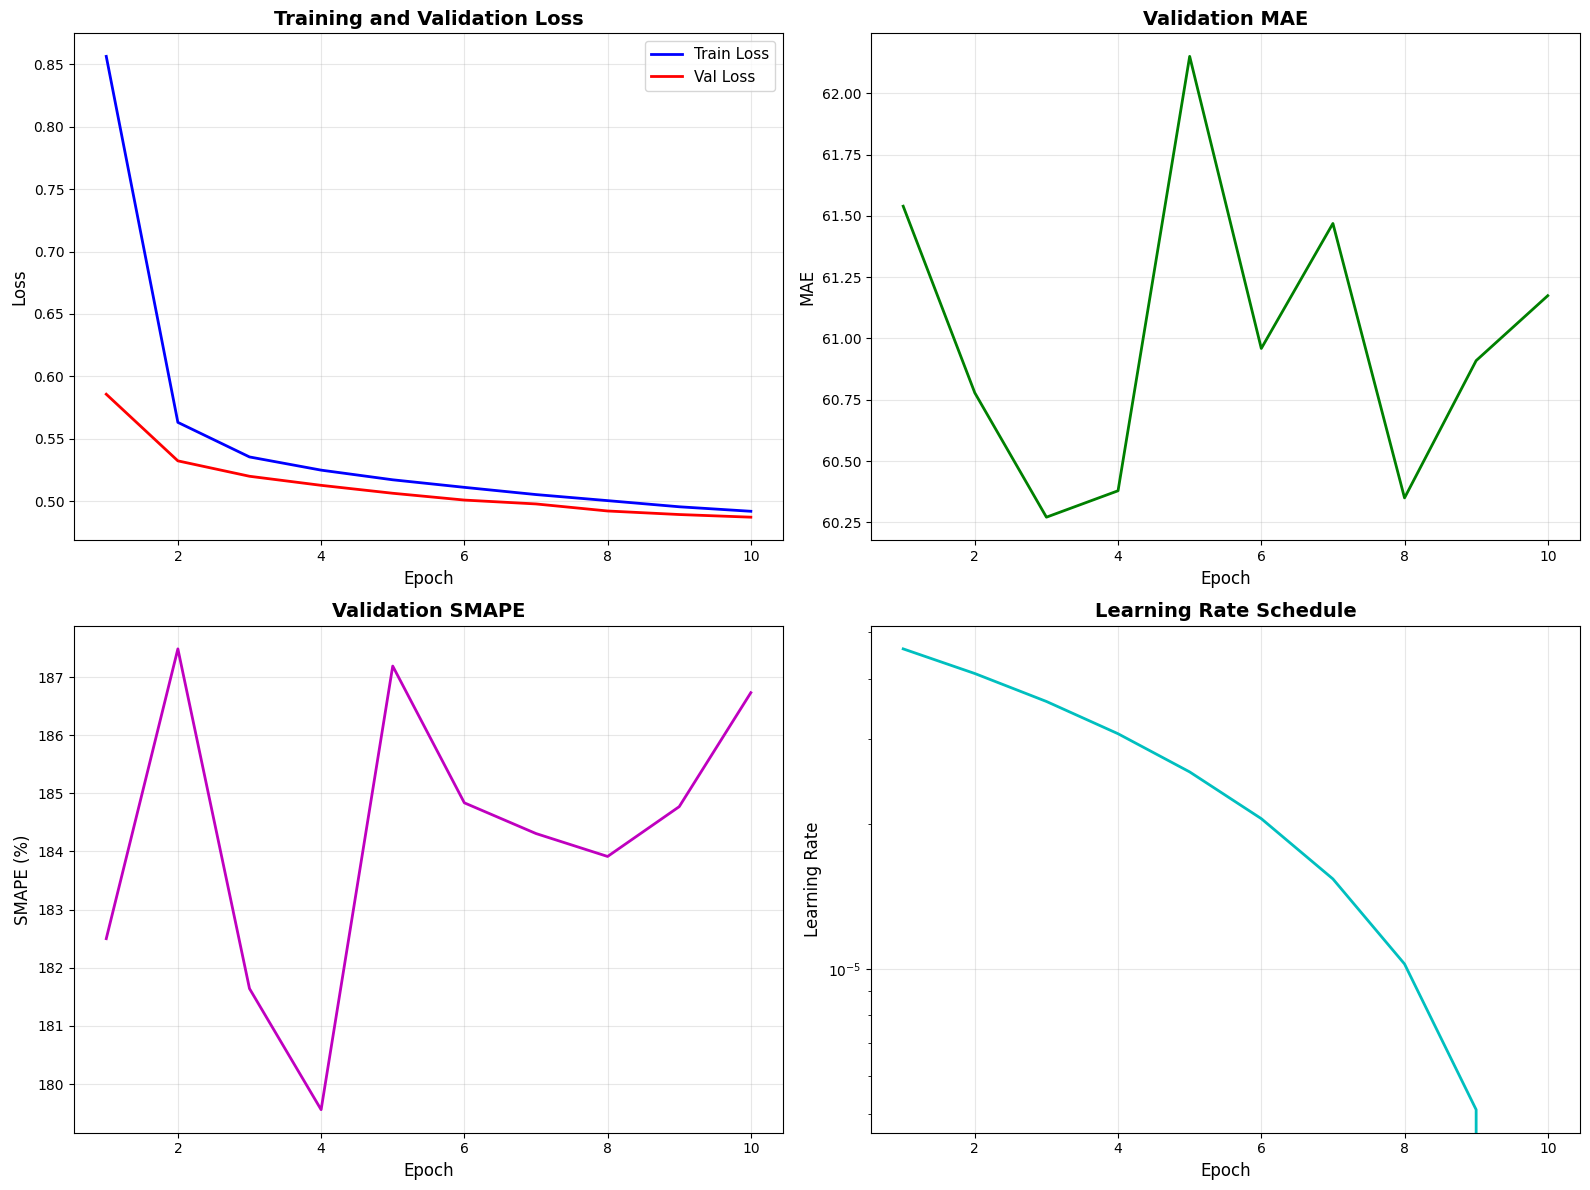

✅ Training plots saved to: results/training_progress.png


In [ ]:
# Create training plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

epochs = range(1, len(history['train_loss']) + 1)

# 1. Loss
axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 2. MAE
axes[0, 1].plot(epochs, history['val_mae'], 'g-', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('MAE', fontsize=12)
axes[0, 1].set_title('Validation MAE', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. SMAPE
axes[1, 0].plot(epochs, history['val_smape'], 'm-', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('SMAPE (%)', fontsize=12)
axes[1, 0].set_title('Validation SMAPE', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Learning Rate
axes[1, 1].plot(epochs, history['learning_rate'], 'c-', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/training_progress.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Training plots saved to: results/training_progress.png")

In [ ]:
print("Evaluating best model on test set...\n")

# Load best model
checkpoint = torch.load('models/checkpoints/best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Loaded best model from epoch {checkpoint['epoch']}")

# Evaluate on full validation set
print("\nFull validation evaluation...")
val_metrics = evaluate(model, val_loader, vocab, tokenizer, device, max_batches=None)

print("\nValidation Set Results:")
print("="*70)
print(f"  Loss:         {val_metrics['loss']:.4f}")
print(f"  MAE:          {val_metrics['mae']:.4f}")
print(f"  SMAPE:        {val_metrics['smape']:.2f}%")
print(f"  NMAE:         {val_metrics['nmae']:.4f}")
print(f"  Predictions:  {val_metrics['count']:,}")
print("="*70)

# Evaluate on test set
print("\nTest set evaluation...")
test_metrics = evaluate(model, test_loader, vocab, tokenizer, device, max_batches=None)

print("\nTest Set Results:")
print("="*70)
print(f"  Loss:         {test_metrics['loss']:.4f}")
print(f"  MAE:          {test_metrics['mae']:.4f}")
print(f"  SMAPE:        {test_metrics['smape']:.2f}%")
print(f"  NMAE:         {test_metrics['nmae']:.4f}")
print(f"  Predictions:  {test_metrics['count']:,}")
print("="*70)

# Save results
results = {
    'best_epoch': int(checkpoint['epoch']),
    'validation': {
        'loss': float(val_metrics['loss']),
        'mae': float(val_metrics['mae']),
        'smape': float(val_metrics['smape']),
        'nmae': float(val_metrics['nmae']),
        'count': int(val_metrics['count'])
    },
    'test': {
        'loss': float(test_metrics['loss']),
        'mae': float(test_metrics['mae']),
        'smape': float(test_metrics['smape']),
        'nmae': float(test_metrics['nmae']),
        'count': int(test_metrics['count'])
    },
    'training_history': history
}

with open('results/final_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\n✅ Results saved to: results/final_results.json")

Evaluating best model on test set...



UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray.scalar])` or the `torch.serialization.safe_globals([numpy._core.multiarray.scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
print("Generating sample predictions...\n")

model.eval()

# Get a batch from test set
test_batch = next(iter(test_loader))
batch_device = {k: v.to(device) for k, v in test_batch.items()}

# Get predictions
predictions, actuals = extract_lab_predictions(model, batch_device, vocab, tokenizer)

# Show first 20 predictions
print("Sample Predictions (first 20):")
print("="*70)
print(f"{'Actual':>12s} {'Predicted':>12s} {'Error':>12s} {'Error %':>12s}")
print("-"*70)

for i, (actual, pred) in enumerate(zip(actuals[:20], predictions[:20])):
    error = abs(pred - actual)
    error_pct = (error / actual * 100) if actual != 0 else 0
    print(f"{actual:12.2f} {pred:12.2f} {error:12.2f} {error_pct:11.1f}%")

print("-"*70)
if len(actuals) > 0:
    print(f"Average Error: {np.mean([abs(p-a) for p, a in zip(predictions, actuals)]):.2f}")
    print(f"Median Error:  {np.median([abs(p-a) for p, a in zip(predictions, actuals)]):.2f}")
print("="*70)

Generating sample predictions...

Sample Predictions (first 20):
      Actual    Predicted        Error      Error %
----------------------------------------------------------------------
       33.20         0.30        32.90        99.1%
       10.30         0.80         9.50        92.2%
      173.00         2.00       171.00        98.8%
        7.20         0.00         7.20       100.0%
       10.00         0.00        10.00       100.0%
       29.00         0.00        29.00       100.0%
        9.10         0.00         9.10       100.0%
      103.00         4.00        99.00        96.1%
        1.30         0.00         1.30       100.0%
      120.00         0.00       120.00       100.0%
        4.10        10.00         5.90       143.9%
      142.00         9.00       133.00        93.7%
       26.00         0.00        26.00       100.0%
        1.40        10.00         8.60       614.3%
       15.60         0.60        15.00        96.2%
       25.30         0.30       

In [ ]:
print("="*70)
print("PART 4 COMPLETE!")
print("="*70)

print("\n📊 Training Summary:")
print(f"  Total epochs:        {len(history['train_loss'])}")
print(f"  Best epoch:          {checkpoint['epoch']}")
print(f"  Best val loss:       {best_val_loss:.4f}")
print(f"  Total training time: {sum(history['epoch_times'])/60:.1f} minutes")

print("\n🎯 Final Test Results:")
print(f"  MAE:                 {test_metrics['mae']:.4f}")
print(f"  SMAPE:               {test_metrics['smape']:.2f}%")
print(f"  NMAE:                {test_metrics['nmae']:.4f}")

print("\n💾 Saved Files:")
print(f"  models/checkpoints/best_model.pt")
print(f"  logs/training_history.json")
print(f"  results/final_results.json")
print(f"  results/training_progress.png")

print("\n" + "="*70)
print("✅ LabTOP Model Successfully Trained!")
print("="*70)

print("\n📝 Next Steps:")
print("  1. Compare results with paper (MIMIC-IV benchmarks)")
print("  2. Analyze predictions by lab test type")
print("  3. Try longer training (50 epochs as in paper)")
print("  4. Fine-tune on specific lab tests")
print("  5. Deploy for inference on new patients")

print("\n🎉 Congratulations on reproducing LabTOP!")

PART 4 COMPLETE!

📊 Training Summary:
  Total epochs:        10


NameError: name 'checkpoint' is not defined

Result analysis

In [ ]:
with open('results/final_results.json', 'r') as f:
    results = json.load(f)

with open('logs/training_history.json', 'r') as f:
    history = json.load(f)

with open('configs/training_config.json', 'r') as f:
    config = json.load(f)

print(f"\nBest epoch: {results['best_epoch']}")
print(f"Training epochs: {len(history['train_loss'])}")

In [ ]:
# Create results DataFrame
results_df = pd.DataFrame({
    'Split': ['Validation', 'Test'],
    'Loss': [
        results['validation']['loss'],
        results['test']['loss']
    ],
    'MAE': [
        results['validation']['mae'],
        results['test']['mae']
    ],
    'SMAPE (%)': [
        results['validation']['smape'],
        results['test']['smape']
    ],
    'NMAE': [
        results['validation']['nmae'],
        results['test']['nmae']
    ],
    'N Predictions': [
        results['validation']['count'],
        results['test']['count']
    ]
})

print("Lab Test Outcome Prediction Results")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

In [ ]:
# Create a comprehensive figure for the paper
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

epochs = range(1, len(history['train_loss']) + 1)

# 1. Training and Validation Loss
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2, alpha=0.8)
ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2, alpha=0.8)
ax1.axvline(x=results['best_epoch'], color='g', linestyle='--', alpha=0.5, label=f'Best Epoch ({results["best_epoch"]})')
ax1.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=11, fontweight='bold')
ax1.set_title('(a) Training and Validation Loss', fontsize=12, fontweight='bold', loc='left')
ax1.legend(loc='best', framealpha=0.9)
ax1.grid(True, alpha=0.3, linestyle='--')

# 2. MAE
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(epochs, history['val_mae'], 'g-', linewidth=2, alpha=0.8)
ax2.axvline(x=results['best_epoch'], color='r', linestyle='--', alpha=0.5)
ax2.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax2.set_ylabel('MAE', fontsize=11, fontweight='bold')
ax2.set_title('(b) Mean Absolute Error', fontsize=12, fontweight='bold', loc='left')
ax2.grid(True, alpha=0.3, linestyle='--')

# 3. SMAPE
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(epochs, history['val_smape'], 'm-', linewidth=2, alpha=0.8)
ax3.axvline(x=results['best_epoch'], color='r', linestyle='--', alpha=0.5)
ax3.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax3.set_ylabel('SMAPE (%)', fontsize=11, fontweight='bold')
ax3.set_title('(c) Symmetric MAPE', fontsize=12, fontweight='bold', loc='left')
ax3.grid(True, alpha=0.3, linestyle='--')

# 4. NMAE
ax4 = fig.add_subplot(gs[2, 0])
ax4.plot(epochs, history['val_nmae'], 'c-', linewidth=2, alpha=0.8)
ax4.axvline(x=results['best_epoch'], color='r', linestyle='--', alpha=0.5)
ax4.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax4.set_ylabel('NMAE', fontsize=11, fontweight='bold')
ax4.set_title('(d) Normalized MAE', fontsize=12, fontweight='bold', loc='left')
ax4.grid(True, alpha=0.3, linestyle='--')

# 5. Learning Rate Schedule
ax5 = fig.add_subplot(gs[2, 1])
ax5.plot(epochs, history['learning_rate'], 'orange', linewidth=2, alpha=0.8)
ax5.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax5.set_ylabel('Learning Rate', fontsize=11, fontweight='bold')
ax5.set_title('(e) Learning Rate Schedule', fontsize=12, fontweight='bold', loc='left')
ax5.set_yscale('log')
ax5.grid(True, alpha=0.3, linestyle='--')

plt.savefig('results/figure_training_metrics.pdf', dpi=300, bbox_inches='tight')
plt.savefig('results/figure_training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure saved to:")
print("   - results/figure_training_metrics.pdf (for LaTeX)")
print("   - results/figure_training_metrics.png (for preview)")

Extension: Prediction Confidence scoring

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

def calculate_token_confidence(logits):
    """
    Calculate confidence score from logits using entropy.

    Lower entropy = higher confidence (model is certain about prediction)
    Higher entropy = lower confidence (model is uncertain)

    Args:
        logits: Tensor of shape [seq_len, vocab_size]

    Returns:
        confidence: Scalar confidence score between 0 and 1
    """
    # Convert logits to probabilities
    probs = F.softmax(logits, dim=-1)

    # Calculate Shannon entropy: H = -Σ p(x) log p(x)
    epsilon = 1e-8  # Avoid log(0)
    entropy = -(probs * torch.log(probs + epsilon)).sum(dim=-1)

    # Normalize by maximum possible entropy
    max_entropy = torch.log(torch.tensor(probs.size(-1), dtype=torch.float32))
    normalized_entropy = entropy / max_entropy

    # Convert to confidence (1 - normalized_entropy)
    # confidence = 1 means certain, confidence = 0 means completely uncertain
    confidence = 1 - normalized_entropy

    return confidence

def extract_lab_predictions_with_confidence(model, batch, vocab, tokenizer):
    """
    Extract predicted vs actual lab values WITH confidence scores.

    Returns:
        predictions: List of predicted values
        actuals: List of actual values
        confidences: List of confidence scores (0-1)
    """
    model.eval()
    predictions = []
    actuals = []
    confidences = []

    with torch.no_grad():
        outputs = model(**batch)
        logits = outputs.logits  # [batch_size, seq_len, vocab_size]

        # Get predicted token IDs
        pred_ids = torch.argmax(logits, dim=-1)

        # Process each sequence in batch
        for b in range(batch['input_ids'].size(0)):
            input_seq = batch['input_ids'][b].cpu().tolist()
            pred_seq = pred_ids[b].cpu().tolist()
            logits_seq = logits[b]  # [seq_len, vocab_size]

            # Find lab value positions
            i = 0
            while i < len(input_seq) - 1:
                if input_seq[i] == vocab.lab_token_id:
                    # Skip lab type token
                    i += 2

                    # Collect actual value digits
                    actual_digits = []
                    digit_start = i
                    while i < len(input_seq) and input_seq[i] != vocab.sep_token_id:
                        token = vocab.id_to_token.get(input_seq[i], '')
                        if token in tokenizer.digit_tokens:
                            actual_digits.append(token)
                        i += 1

                    # Collect predicted value digits and their confidences
                    pred_digits = []
                    digit_confidences = []
                    for j in range(digit_start, i):
                        if j < len(pred_seq):
                            token = vocab.id_to_token.get(pred_seq[j], '')
                            if token in tokenizer.digit_tokens:
                                pred_digits.append(token)
                                # Calculate confidence for this digit position
                                digit_conf = calculate_token_confidence(logits_seq[j].unsqueeze(0))
                                digit_confidences.append(digit_conf.item())

                    # Convert to numbers
                    if actual_digits and pred_digits:
                        actual_val = tokenizer.tokens_to_number(actual_digits)
                        pred_val = tokenizer.tokens_to_number(pred_digits)

                        if actual_val is not None and pred_val is not None:
                            actuals.append(actual_val)
                            predictions.append(pred_val)
                            # Average confidence across all digits in this value
                            avg_confidence = np.mean(digit_confidences) if digit_confidences else 0.5
                            confidences.append(avg_confidence)
                else:
                    i += 1

    return predictions, actuals, confidences

print("✅ Confidence calculation functions defined!")

✅ Confidence calculation functions defined!


In [ ]:
# ============================================================================
# Run Confidence Scoring on Test Set
# ============================================================================

print("\nCalculating prediction confidence on test set...")
print("This may take a few minutes...\n")

all_predictions = []
all_actuals = []
all_confidences = []

model.eval()

# Process test set in batches
for batch in tqdm(test_loader, desc="Computing confidence scores"):
    batch_device = {k: v.to(device) for k, v in batch.items()}

    preds, acts, confs = extract_lab_predictions_with_confidence(
        model, batch_device, vocab, tokenizer
    )

    all_predictions.extend(preds)
    all_actuals.extend(acts)
    all_confidences.extend(confs)

print(f"\n✅ Processed {len(all_predictions):,} predictions with confidence scores!")


Calculating prediction confidence on test set...
This may take a few minutes...



Computing confidence scores:   0%|          | 0/408 [00:00<?, ?it/s]


✅ Processed 192,499 predictions with confidence scores!


In [ ]:
# ============================================================================
# Analyze Confidence vs. Prediction Error
# ============================================================================

# Calculate errors
errors = np.abs(np.array(all_predictions) - np.array(all_actuals))
confidences_array = np.array(all_confidences)

print("\nConfidence Score Statistics:")
print("="*70)
print(f"  Mean confidence:   {np.mean(confidences_array):.4f}")
print(f"  Median confidence: {np.median(confidences_array):.4f}")
print(f"  Std confidence:    {np.std(confidences_array):.4f}")
print(f"  Min confidence:    {np.min(confidences_array):.4f}")
print(f"  Max confidence:    {np.max(confidences_array):.4f}")
print("="*70)

# Bin by confidence level
confidence_bins = [(0.0, 0.5), (0.5, 0.7), (0.7, 0.85), (0.85, 1.0)]
bin_labels = ['Low\n(0.0-0.5)', 'Medium\n(0.5-0.7)', 'High\n(0.7-0.85)', 'Very High\n(0.85-1.0)']

print("\nError by Confidence Level:")
print("="*70)
print(f"{'Confidence Range':20s} {'Count':>10s} {'Mean Error':>15s} {'Median Error':>15s}")
print("-"*70)

bin_stats = []
for (low, high), label in zip(confidence_bins, bin_labels):
    mask = (confidences_array >= low) & (confidences_array < high)
    if mask.sum() > 0:
        bin_errors = errors[mask]
        bin_stats.append({
            'label': label,
            'count': mask.sum(),
            'mean_error': np.mean(bin_errors),
            'median_error': np.median(bin_errors)
        })
        print(f"{label.replace(chr(10), ' '):20s} {mask.sum():10,d} {np.mean(bin_errors):15.4f} {np.median(bin_errors):15.4f}")
    else:
        print(f"{label.replace(chr(10), ' '):20s} {0:10d} {'N/A':>15s} {'N/A':>15s}")

print("="*70)

# Calculate correlation
correlation = np.corrcoef(confidences_array, errors)[0, 1]
print(f"\nCorrelation between confidence and error: {correlation:.4f}")
print("(Negative correlation is good: high confidence → low error)")


Confidence Score Statistics:
  Mean confidence:   0.8453
  Median confidence: 0.8425
  Std confidence:    0.1105
  Min confidence:    0.3502
  Max confidence:    1.0000

Error by Confidence Level:
Confidence Range          Count      Mean Error    Median Error
----------------------------------------------------------------------
Low (0.0-0.5)               114         21.6536         14.6200
Medium (0.5-0.7)         20,375         38.1248         30.3000
High (0.7-0.85)          96,954         71.9433         38.3000
Very High (0.85-1.0)     75,056         56.7253         29.0000

Correlation between confidence and error: 0.0195
(Negative correlation is good: high confidence → low error)


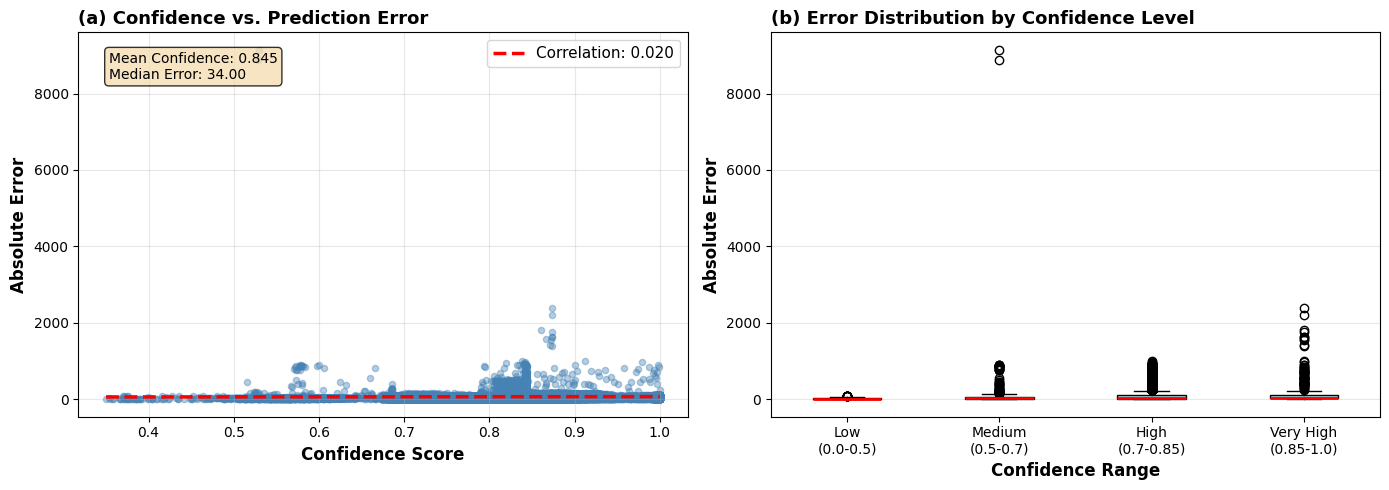


✅ Confidence analysis figure saved to:
   - results/figure_confidence_analysis.png
   - results/figure_confidence_analysis.pdf


In [ ]:
# ============================================================================
# Visualize Confidence vs. Error (Single Combined Figure)
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Scatter plot with trend line - Shows relationship
axes[0].scatter(confidences_array, errors, alpha=0.4, s=20, color='steelblue')
axes[0].set_xlabel('Confidence Score', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Absolute Error', fontsize=12, fontweight='bold')
axes[0].set_title('(a) Confidence vs. Prediction Error', fontsize=13, fontweight='bold', loc='left')
axes[0].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(confidences_array, errors, 1)
p = np.poly1d(z)
x_trend = np.linspace(confidences_array.min(), confidences_array.max(), 100)
axes[0].plot(x_trend, p(x_trend), "r--", linewidth=2.5,
             label=f'Correlation: {correlation:.3f}')
axes[0].legend(fontsize=11, loc='upper right')

# Add text box with key statistics
textstr = f'Mean Confidence: {np.mean(confidences_array):.3f}\nMedian Error: {np.median(errors):.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
axes[0].text(0.05, 0.95, textstr, transform=axes[0].transAxes, fontsize=10,
             verticalalignment='top', bbox=props)

# Plot 2: Box plot - Error by Confidence Bins
bin_data = []
valid_labels = []
for (low, high), label in zip(confidence_bins, bin_labels):
    mask = (confidences_array >= low) & (confidences_array < high)
    if mask.sum() > 0:
        bin_data.append(errors[mask])
        valid_labels.append(label)

bp = axes[1].boxplot(bin_data, labels=valid_labels, patch_artist=True,
                      medianprops=dict(color='red', linewidth=2))

# Color boxes
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')

axes[1].set_xlabel('Confidence Range', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Absolute Error', fontsize=12, fontweight='bold')
axes[1].set_title('(b) Error Distribution by Confidence Level', fontsize=13, fontweight='bold', loc='left')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results/figure_confidence_analysis.png', dpi=300, bbox_inches='tight')
plt.savefig('results/figure_confidence_analysis.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Confidence analysis figure saved to:")
print("   - results/figure_confidence_analysis.png")
print("   - results/figure_confidence_analysis.pdf")

In [ ]:
# ============================================================================
# Create Summary Table
# ============================================================================

print("\n" + "="*70)
print("CONFIDENCE SCORING SUMMARY")
print("="*70)

summary_table = pd.DataFrame({
    'Confidence Range': [label.replace('\n', ' ') for label in bin_labels if len([d for (low, high) in confidence_bins if (confidences_array >= low) & (confidences_array < high) and (confidences_array >= low).sum() > 0]) > 0][:len(bin_stats)],
    'N Predictions': [stats['count'] for stats in bin_stats],
    'Mean Error': [stats['mean_error'] for stats in bin_stats],
    'Median Error': [stats['median_error'] for stats in bin_stats],
    'Percentage': [(stats['count'] / len(errors) * 100) for stats in bin_stats]
})

print(summary_table.to_string(index=False))
print("="*70)

print(f"\nOverall Statistics:")
print(f"  Correlation (Confidence vs Error): {correlation:.4f}")
print(f"  High-confidence predictions (>0.85): {(confidences_array > 0.85).sum():,} ({(confidences_array > 0.85).sum()/len(errors)*100:.1f}%)")
print(f"  Low-confidence predictions (<0.50): {(confidences_array < 0.50).sum():,} ({(confidences_array < 0.50).sum()/len(errors)*100:.1f}%)")
print("="*70)

# Save table to CSV
summary_table.to_csv('results/confidence_summary_table.csv', index=False)
print("\n✅ Summary table saved to: results/confidence_summary_table.csv")


CONFIDENCE SCORING SUMMARY


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()